# Introduction to Deep Learning 67822 - [Ex3](https://docs.google.com/document/d/12ZI1Q5cpf2aClCAIB5Tr4hcF0gLowrVbG7cNWXoHFpY/edit?pli=1&tab=t.0)

## **Programing Task:** Sentiment Analysis for the IMDB Movies Reviews Dataset

The dataset consists of 50,000 annotated reviews. Each review is a plain text describing the viewers’ experience and opinion on the movie watched. The dataset consists of highly polar reviews and contains binary labels (positive and negative) based on the number of stars the movie received by the viewers. Some reviews are very long, but we will consider only the first 100 words they contain.

In this exercise we design networks that predict the viewers’ sentiment (positive/negative) towards the movies they watched based on the review they wrote. We will compare the following four different strategies:

1. The use of a simple Elman RNN  
2. The use of a simple GRU  
3. The use of a global average pooling. In this case every word goes through an MLP that result in a scalar, we call “*sub-prediction score”*, and these scores are then summed together to provide the final prediction  
4. Adding a local self-attention layer to Strategy \#3 in order to achieve crossword reasoning (contextualization)

The exercise comes with a partial code that loads the reviews from the dataset, and processes them into a long list of lower-case text (100 words, no punctuation/sentences, no special characters). Longer reviews are truncated, shorter ones are padded. This pre-processing uses the GloVe word embedding which maps every word into a 100-dimensional vector. To avoid over-fitting over this small dataset we do not allow this embedding to train; treat it as a frozen part of the model. You can read more about this embedding [here](https://nlp.stanford.edu/projects/glove/). Some parts of these pre-processing steps were taken from [this](https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/) tutorial.

The exercise consists of the following specific tasks. 

### Setup

#### Logs Directory Setup

In [1]:
import os
# Create directories for organized output
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True) 
os.makedirs("logs", exist_ok=True)

#### Imports

In [2]:
import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np
import loader as ld

# CODE_CHANGE: Importing visualization module + Importing loader modules
################################################
from viz import plot_losses_and_accuracy
from loader import embedding_size, device, MAX_LENGTH, preprocess_review, tokinize, device
################################################

#### Setting up constants

In [3]:
batch_size = 32
output_size = 2
hidden_size = 64        # to experiment with

# CODE_CHANGE: I moved those flags to the training function
"""################################################
run_recurrent = True    # else run Token-wise MLP
use_RNN = True          # otherwise GRU
atten_size = 0          # atten > 0 means using restricted self atten
################################################"""

reload_model = False
num_epochs = 10
learning_rate = 0.001
test_interval = 50

#### getting IMDB dataset

In [4]:
# Loading sataset, use toy = True for obtaining a smaller dataset
train_dataset, test_dataset, num_words, input_size = ld.get_data_set(batch_size)

#### General Training/testing wrapper function based of `sentiment_start.py`

In [25]:
# CODE_CHANGE: Wrapped all the given training code in a function
################################################
def train_model(model, model_name, train_dataset, test_dataset, num_words, criterion, optimizer, run_recurrent, use_RNN, use_MLP, atten_size):
################################################

    # CODE_CHANGE: Added an accuracy and loss logger
    ################################################
    result_logger = []
    train_acc = 0.5
    test_acc = 0.5
    ################################################

    # CODE_CHANGE: Added code for saving the model text output.
    ################################################
    with open(f"logs/models_log.txt", "a") as f:
        log_text = (f"Running model: {model_name}")
        f.write(log_text + "\n")
    ################################################

    train_loss = 1.0
    test_loss = 1.0

    for epoch in range(num_epochs):

        itr = 0 # iteration counter within each epoch

        for labels, reviews, reviews_text in train_dataset:   # getting training batches

            itr = itr + 1

            if (itr + 1) % test_interval == 0:
                test_iter = True
                labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch 
            else:
                test_iter = False

            # Recurrent nets (RNN/GRU)

            if run_recurrent:
                hidden_state = model.init_hidden(int(labels.shape[0]))

                for i in range(num_words):
                    output, hidden_state = model(reviews[:,i,:], hidden_state)  # HIDE

            else:  

            # Token-wise networks (MLP / MLP + Atten.) 
            
                sub_score = []
                if use_MLP:
                    # calculate MLP prediction :
                    # output: [positive sentence probability,
                    #          negative sentence probability]
                    # sub_score: [positive word probability,
                    #               negative word probability]
                    output, sub_score = model(reviews)
                elif atten_size > 0:                
                    # MLP + atten
                    sub_score, atten_weights = model(reviews)
                    output = torch.mean(sub_score, dim=1)  # Need to compute output for attention case

                else:
                     raise ValueError("Invalid configuration: Please enable one of use_MLP / atten_size / run_recurrent")
                # In original code mean calculation for sub_score was here
                
            # cross-entropy loss

            loss = criterion(output, labels)

            # CODE_CHANGE: Added accuracy calculation
            ################################################
            with torch.no_grad():
                actual = torch.argmax(labels, dim=1)
                predicted = torch.argmax(output, dim=1)
                correct = (predicted == actual).float().sum()
                accuracy = correct / labels.size(0)
            ################################################
            # optimize in training iterations

            if not test_iter:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # averaged losses
            if test_iter:
                test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss

                # CODE_CHANGE: Update accuracy
                ################################################
                test_acc = 0.8 * float(accuracy) + 0.2 * test_acc
                ################################################

            else:
                train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss

                # CODE_CHANGE: Update accuracy
                ################################################
                train_acc = 0.9 * float(accuracy) + 0.1 * train_acc
                ################################################
            if test_iter:

                # CODE_CHANGE:
                # Moved this printing code to the end of epoch loop
                # in order to print only per epoch for more clarity.
                # the data per interval is still logged to a file,
                # and will be shown in the plots.
                ################################################
                """
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Step [{itr + 1}/{len(train_dataset)}], "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Test Loss: {test_loss:.4f}"
                )
                """
                ################################################


                # CODE_CHANGE: Added code for saving the model text output.
                ################################################
                with open(f"logs/models_log.txt", "a") as f:
                    log_text = (
                        f"Epoch [{epoch + 1}/{num_epochs}] | "
                        f"Step [{itr + 1}/{len(train_dataset)}] | "
                        f"Train Loss: {train_loss:.4f} | "
                        f"Test Loss: {test_loss:.4f} | "
                        f"Train Acc: {train_acc:.4f} | "
                        f"Test Acc: {test_acc:.4f}"
                    )
                    f.write(log_text + "\n")
                ################################################
                

                # CODE_CHANGE: Added code to log the losses and accuracies
                ################################################
                result_logger.append({
                    'epoch': epoch + 1,
                    'step': itr + 1,
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                    'train_acc': train_acc,
                    'test_acc': test_acc
                })
                ################################################


                if not run_recurrent:
                    nump_subs = sub_score.detach().numpy()
                    labels = labels.detach().numpy()
                    # print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])
                
                # saving the model
                # CODE_CHANGE: dded code to save the model in a specific folder
                ################################################
                torch.save(model.state_dict(), f"models/{model_name}.pth")
                ################################################

        
        # CODE_CHANGE:
        # printing code is now in the end of the epoch loop
        # instead of per interval, for more clarity.
        # it also print accuracies now.
        ################################################         
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] | "
            f"Step [{itr}/{len(train_dataset)}] | "
            f"Train Loss: {train_loss:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )
        ################################################


    # CODE_CHANGE: returning losses and accuracies logger
    ################################################
    return result_logger
    ################################################


### 1.
Fill in the missing lines of code in the `RNN` and `GRU` cells functions.

The `RNN` contains some lines which you may find helpful (or choose to omit and implement on your own).

The gates and update operators should consist of a single FC layer (hidden state dim. should be between 64-128 for the lowest test error).

The convention of the tensors for these recurrent networks is $N_{batch}$ x $N_{word}$ x $N_{features}$, or **batch element x “time index” x feature vector coordinate**. So the recurrence (your iteration in the code) should apply and advance on the second axis.

Once the review is parsed, its hidden-state should pass through an MLP which produces the final output sentiment prediction (a 2-class one hot vector). Do not use a single output sentiment scalar for reasons that we will see below.

Run each of these recurrent network architectures, describe your experiments with two different hidden-state dimensions (small/large),and the train/test accuracies obtained (with plots).

Explain what could lead to the different results you found in the experiment (both `RNN` vs `GRU` and hidden state size). Come up with a test review of your own that demonstrates the different capabilities of the two recurrent models. 

Add this review (and maybe variations of it that you’ve experimented with), and the results obtained and your explanation to the report.

**Add to your PDF the code lines where you combine input with hidden state and apply the activation function in your `RNN`. In addition, add the lines that compute the reset gate and update gate in the `GRU`**

#### `RNN` Class Implementation

In [6]:
# Implements RNN Unit
class ExRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExRNN, self).__init__()

        self.hidden_size = hidden_size
        self.sigmoid = torch.sigmoid

        # RNN Cell weights
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        # CODE_CHANGE: what else?
        ##################################################
        self.out = nn.Linear(hidden_size, output_size)
        ##################################################


    def name(self):
        return "RNN"

    def forward(self, x, hidden_state):

        # CODE_CHANGE: Implementation of RNN cell
        ##################################################
        # Concatenate input and hidden state
        combined = torch.cat((x, hidden_state), dim=1)  # Shape: (batch_size, input_size + hidden_size)

        # Apply linear transformation + tanh activation
        hidden = torch.tanh(self.in2hidden(combined))  # Updated hidden state

        output = self.out(hidden)  # final sentiment prediction
        ##################################################
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size)

#### `GRU` Class Implementation

In [7]:
# Implements GRU Unit
class ExGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExGRU, self).__init__()
        self.hidden_size = hidden_size
        # GRU Cell weights
        # self.something =
        # etc ...

        # CODE_CHANGE: Initialize GRU Cell weights
        ##################################################
        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)  # update gate
        self.W_r = nn.Linear(input_size + hidden_size, hidden_size)  # reset gate
        self.W_h = nn.Linear(input_size + hidden_size, hidden_size)  # candidate hidden
        self.out = nn.Linear(hidden_size, output_size)
        ##################################################

    def name(self):
        return "GRU"

    def forward(self, x, hidden_state):
        # CODE_CHANGE: Implementation of GRU cell
        ##################################################
        # missing implementation
        combined = torch.cat((x, hidden_state), dim=1)

        # GRU gates
        z = torch.sigmoid(self.W_z(combined))     # update gate
        r = torch.sigmoid(self.W_r(combined))     # reset gate

        # candidate hidden state uses reset-applied hidden
        combined_reset = torch.cat((x, r * hidden_state), dim=1)
        h_tilde = torch.tanh(self.W_h(combined_reset))

        # final hidden state
        hidden = (1 - z) * hidden_state + z * h_tilde

        output = self.out(hidden)  # final sentiment prediction
        ##################################################
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size)

#### Comparing `RNN` vs `GRU` with 64/128 hidden sizes

Running model: Q1_ExRNN_hidden64
Epoch [1/10] | Step [938/938] | Train Loss: 0.6602 | Test Loss: 0.7255 | Train Acc: 0.5707 | Test Acc: 0.5474
Epoch [2/10] | Step [938/938] | Train Loss: 0.7039 | Test Loss: 0.6825 | Train Acc: 0.6159 | Test Acc: 0.5241
Epoch [3/10] | Step [938/938] | Train Loss: 0.6900 | Test Loss: 0.7481 | Train Acc: 0.6107 | Test Acc: 0.5126
Epoch [4/10] | Step [938/938] | Train Loss: 0.7849 | Test Loss: 0.6738 | Train Acc: 0.2901 | Test Acc: 0.6033
Epoch [5/10] | Step [938/938] | Train Loss: 0.6626 | Test Loss: 0.7098 | Train Acc: 0.6666 | Test Acc: 0.4474
Epoch [6/10] | Step [938/938] | Train Loss: 0.6569 | Test Loss: 0.6899 | Train Acc: 0.6718 | Test Acc: 0.4054
Epoch [7/10] | Step [938/938] | Train Loss: 0.6368 | Test Loss: 0.6599 | Train Acc: 0.7271 | Test Acc: 0.5883
Epoch [8/10] | Step [938/938] | Train Loss: 0.7040 | Test Loss: 0.6887 | Train Acc: 0.5099 | Test Acc: 0.5410
Epoch [9/10] | Step [938/938] | Train Loss: 0.6601 | Test Loss: 0.6887 | Train Acc: 0.6

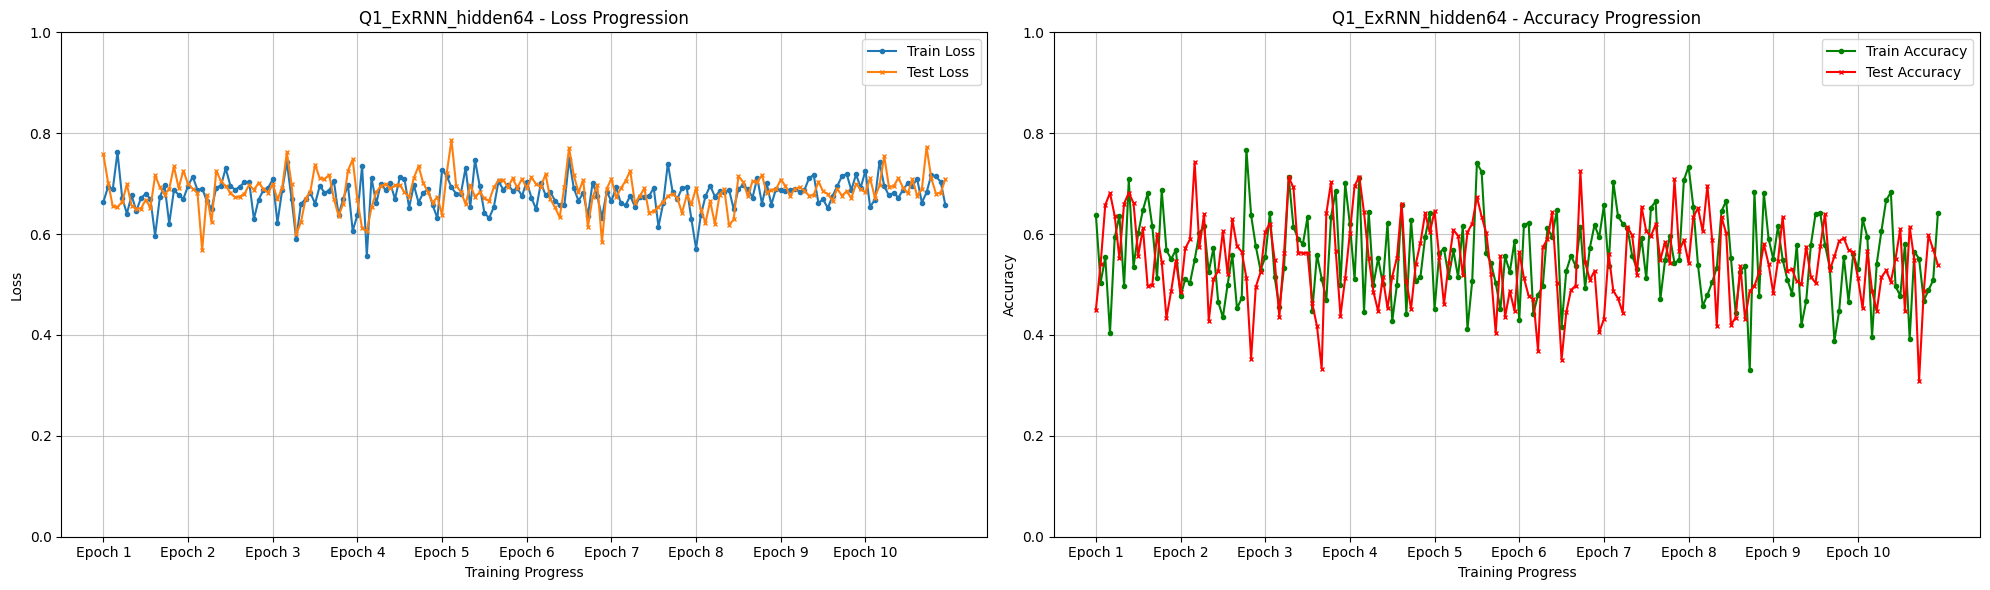

Running model: Q1_ExGRU_hidden64
Epoch [1/10] | Step [938/938] | Train Loss: 0.2385 | Test Loss: 0.5391 | Train Acc: 0.8650 | Test Acc: 0.7497
Epoch [2/10] | Step [938/938] | Train Loss: 0.4375 | Test Loss: 0.3611 | Train Acc: 0.8158 | Test Acc: 0.7838
Epoch [3/10] | Step [938/938] | Train Loss: 0.2350 | Test Loss: 0.3669 | Train Acc: 0.9252 | Test Acc: 0.8196
Epoch [4/10] | Step [938/938] | Train Loss: 0.3612 | Test Loss: 0.4381 | Train Acc: 0.8660 | Test Acc: 0.7751
Epoch [5/10] | Step [938/938] | Train Loss: 0.1225 | Test Loss: 0.3151 | Train Acc: 0.9932 | Test Acc: 0.8652
Epoch [6/10] | Step [938/938] | Train Loss: 0.4739 | Test Loss: 0.3399 | Train Acc: 0.7068 | Test Acc: 0.8332
Epoch [7/10] | Step [938/938] | Train Loss: 0.2771 | Test Loss: 0.4815 | Train Acc: 0.8742 | Test Acc: 0.7768
Epoch [8/10] | Step [938/938] | Train Loss: 0.2209 | Test Loss: 0.3845 | Train Acc: 0.9374 | Test Acc: 0.7990
Epoch [9/10] | Step [938/938] | Train Loss: 0.1806 | Test Loss: 0.4312 | Train Acc: 0.9

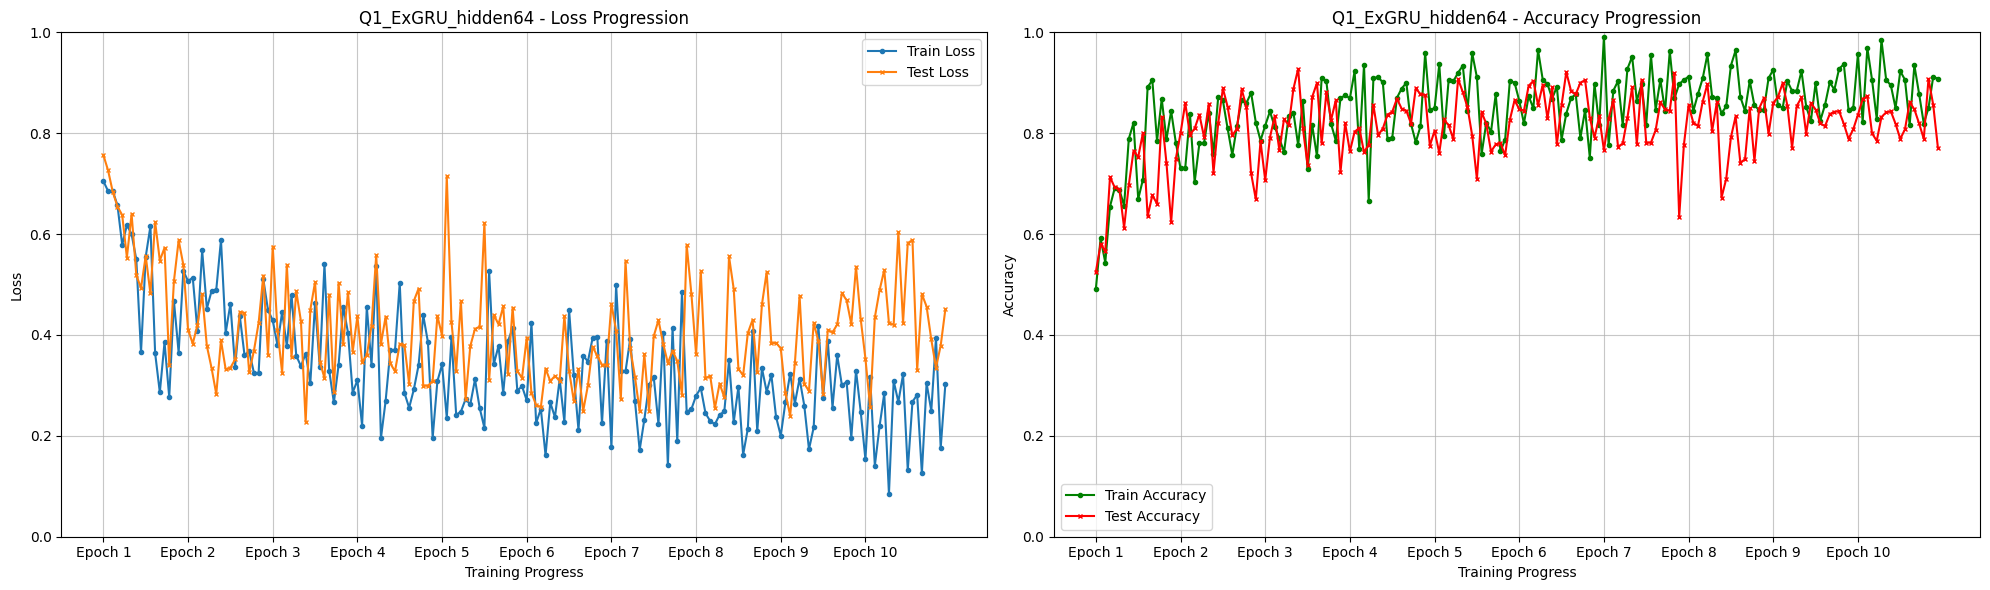

Running model: Q1_ExRNN_hidden128
Epoch [1/10] | Step [938/938] | Train Loss: 0.7795 | Test Loss: 0.6819 | Train Acc: 0.2806 | Test Acc: 0.6272
Epoch [2/10] | Step [938/938] | Train Loss: 0.7092 | Test Loss: 0.7141 | Train Acc: 0.5002 | Test Acc: 0.5145
Epoch [3/10] | Step [938/938] | Train Loss: 0.6726 | Test Loss: 0.6879 | Train Acc: 0.5651 | Test Acc: 0.5543
Epoch [4/10] | Step [938/938] | Train Loss: 0.6455 | Test Loss: 0.6861 | Train Acc: 0.6326 | Test Acc: 0.4772
Epoch [5/10] | Step [938/938] | Train Loss: 0.6402 | Test Loss: 0.6869 | Train Acc: 0.6761 | Test Acc: 0.6323
Epoch [6/10] | Step [938/938] | Train Loss: 0.7046 | Test Loss: 0.7469 | Train Acc: 0.5181 | Test Acc: 0.4270
Epoch [7/10] | Step [938/938] | Train Loss: 0.6897 | Test Loss: 0.7124 | Train Acc: 0.6170 | Test Acc: 0.4127
Epoch [8/10] | Step [938/938] | Train Loss: 0.6851 | Test Loss: 0.7936 | Train Acc: 0.6188 | Test Acc: 0.4846
Epoch [9/10] | Step [938/938] | Train Loss: 0.6769 | Test Loss: 0.6882 | Train Acc: 0.

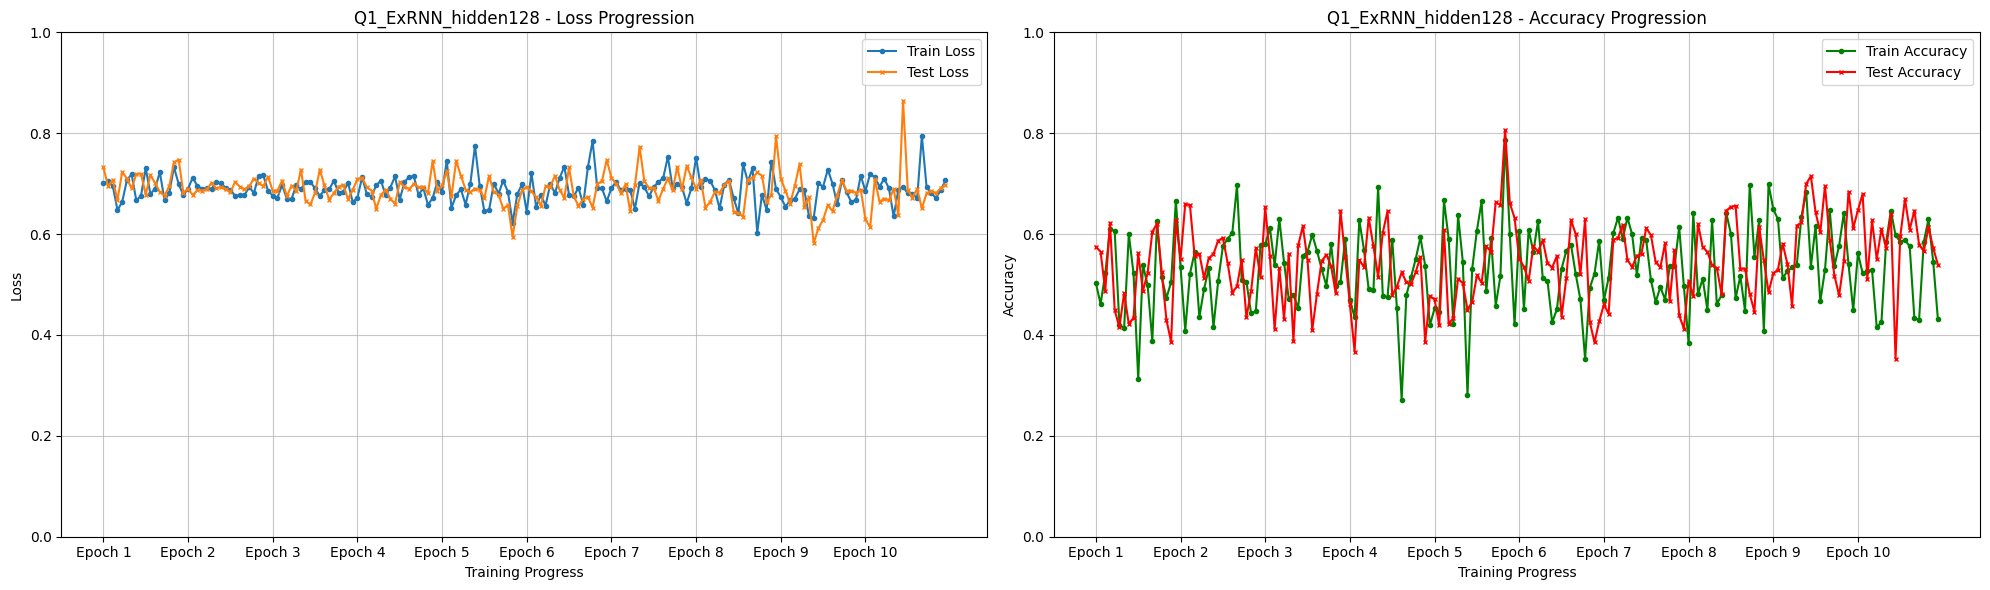

Running model: Q1_ExGRU_hidden128
Epoch [1/10] | Step [938/938] | Train Loss: 0.5839 | Test Loss: 0.3152 | Train Acc: 0.6342 | Test Acc: 0.8560
Epoch [2/10] | Step [938/938] | Train Loss: 0.4465 | Test Loss: 0.3477 | Train Acc: 0.8134 | Test Acc: 0.8376
Epoch [3/10] | Step [938/938] | Train Loss: 0.3482 | Test Loss: 0.3399 | Train Acc: 0.8207 | Test Acc: 0.8493
Epoch [4/10] | Step [938/938] | Train Loss: 0.2514 | Test Loss: 0.3364 | Train Acc: 0.9319 | Test Acc: 0.8580
Epoch [5/10] | Step [938/938] | Train Loss: 0.4073 | Test Loss: 0.2964 | Train Acc: 0.8102 | Test Acc: 0.8649
Epoch [6/10] | Step [938/938] | Train Loss: 0.5110 | Test Loss: 0.3061 | Train Acc: 0.7650 | Test Acc: 0.8694
Epoch [7/10] | Step [938/938] | Train Loss: 0.2542 | Test Loss: 0.4026 | Train Acc: 0.8213 | Test Acc: 0.8208
Epoch [8/10] | Step [938/938] | Train Loss: 0.3374 | Test Loss: 0.6396 | Train Acc: 0.8843 | Test Acc: 0.6806
Epoch [9/10] | Step [938/938] | Train Loss: 0.3765 | Test Loss: 0.5740 | Train Acc: 0.

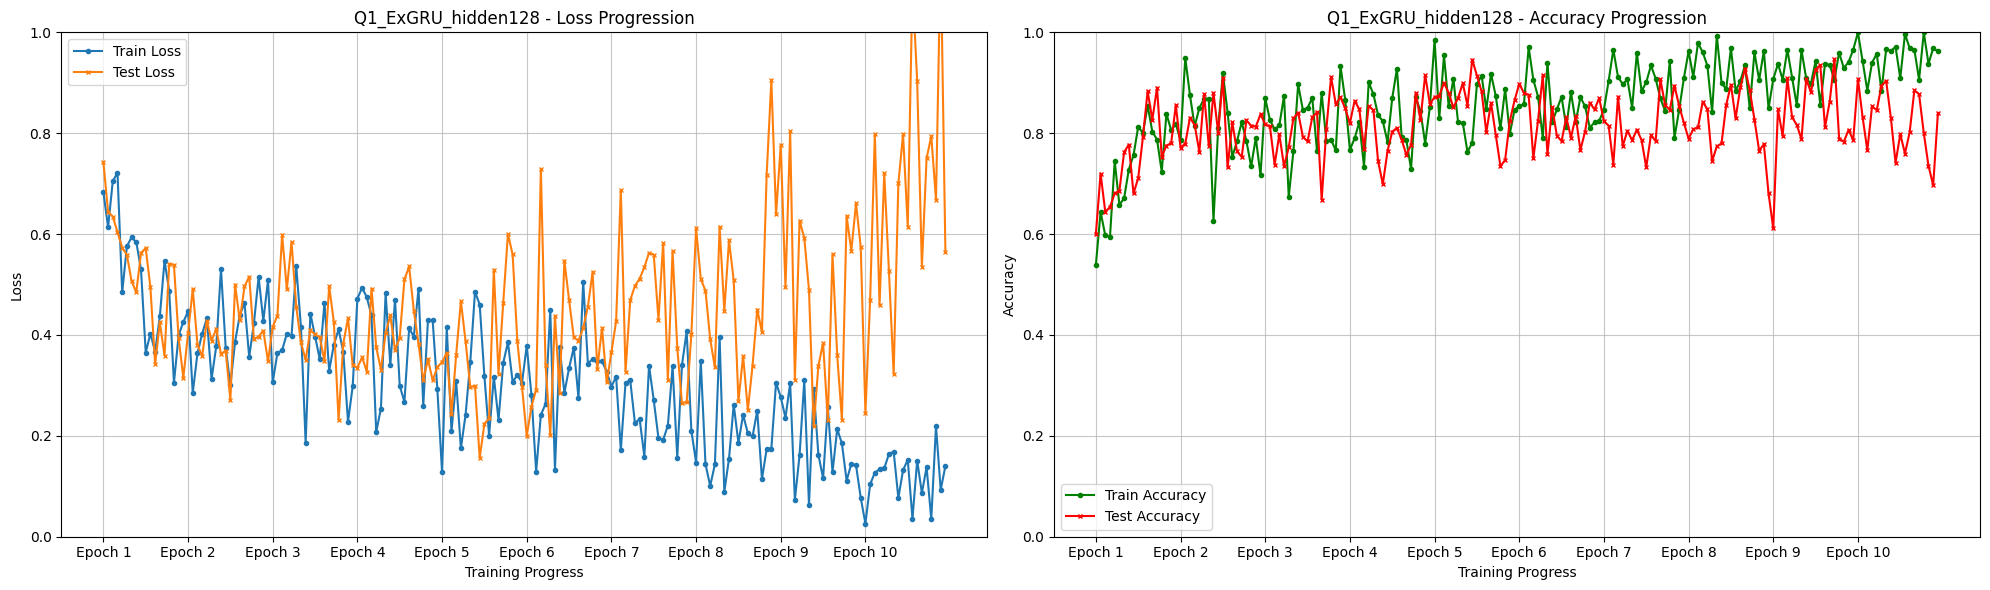

In [8]:
# Compare RNN vs GRU across hidden sizes
for hidden_size in [64, 128]:  # Sweep over small and large hidden states
    for model_class in [ExRNN, ExGRU]: # Sweep over RNN and GRU
        if model_class == ExRNN:
            use_RNN = True
        elif model_class == ExGRU:
            use_RNN = False
        model_name = f"Q1_{model_class.__name__}_hidden{hidden_size}"
        print("=" * 110)
        print(f"Running model: {model_name}")

        model = model_class(input_size, output_size, hidden_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        log_loss = train_model(
            model, model_name, train_dataset, test_dataset,
            num_words, criterion, optimizer, run_recurrent=True, use_RNN=use_RNN, use_MLP=False, atten_size=0
        )
        plot_losses_and_accuracy(log_loss, model_name)

#### Experimental Results Summary

From the training logs:

- **RNN (hidden=64)** final test accuracy: 53.9%  
- **RNN (hidden=128)** final test accuracy: 53.9%  
- **GRU (hidden=64)** final test accuracy: 77.1%  
- **GRU (hidden=128)** final test accuracy: 83.9%  

**Key findings:**
- **GRU vs. RNN:** GRUs beat RNNs by ~23 pp on test accuracy, despite identical parameter budgets.  

- **Convergence speed:**  
   - GRU (64) hits ~78% by epoch 3.  
   - GRU (128) peaks at ~86.9% (epoch 6), with slight overfitting thereafter.  
   - Both RNNs plateau near 54%, showing almost no learning.

- **Hidden-size effects:**  
   - RNNs: no real gain from doubling hidden units (bottlenecked by vanishing gradients).  
   - GRUs: +6.8 pp from 64→128, trading some generalization for capacity.

**Why GRU outperforms RNN (in-depth):**
- **Dual-gate mechanism:**  
  - The **reset gate** $r_t$ controls how much of the past state to ignore when computing the candidate state $\tilde{h}_t$:  
    $$
      r_t = \sigma(W_r[x_t, h_{t-1}]),
      \quad
      \tilde{h}_t = \tanh\bigl(W_h[x_t, r_t \odot h_{t-1}]\bigr).
    $$  
    This behaves like a dynamic skip connection, letting the network “zoom in” on new inputs when needed.  
  - The **update gate** $z_t$ decides how much of $\tilde{h}_t$ vs. the old $h_{t-1}$ to use:  
    $$
      z_t = \sigma(W_z[x_t, h_{t-1}]),
      \quad
      h_t = (1 - z_t)\odot h_{t-1} + z_t \odot \tilde{h}_t.
    $$  
    By interpolating between old and new states, it smooths transitions and prevents abrupt changes that can destabilize learning.
- **Gradient highways:** When $z_t\approx1$, the GRU passes $h_{t-1}$ almost unchanged, creating a near-linear path for gradients. This fights the vanishing/exploding gradient problem that cripples vanilla RNNs over 100-step sequences.
- **Parameter efficiency:** GRUs omit LSTM’s output gate, using only two gates. Fewer parameters means faster training and less over-fitting risk, while still reaping the core benefits of gating.
- **Practical evidence:**  
  - **RNNs** show erratic loss and hover near chance accuracy, indicating failed gradient propagation.  
  - **GRUs** converge quickly and stably, exploiting long-range context (e.g., negations, contrastive clauses) that simple RNNs cannot learn.



#### Test Custom Reviews
the text reviews used for testing the models and their labels are set in the `loader.py` file.

In [9]:
# Test custom reviews demonstrating RNN vs GRU differences
import torch

# Define the models and their configurations
model_configs = [
    {"class": ExRNN, "hidden_size": 128, "name": "RNN_128"},
    {"class": ExGRU, "hidden_size": 128, "name": "GRU_128"},
]

# Load the trained models
loaded_models = {}
for config in model_configs:
    model_path = f"models/Q1_{config['class'].__name__}_hidden{config['hidden_size']}.pth"
    
    try:
        model = config["class"](input_size, output_size, config["hidden_size"])
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        loaded_models[config["name"]] = model
        print(f"Loaded: {model_path}")
    except FileNotFoundError:
        print(f"Model not found: {model_path} - Please check if training completed")
    except Exception as e:
        print(f"Error loading {model_path}: {e}")

# Make sure we have both models loaded
if "RNN_128" not in loaded_models or "GRU_128" not in loaded_models:
    print("Error: Both models need to be trained first!")
else:
    # 1) Load only the custom reviews
    _, custom_test_loader, num_words, _ = ld.get_data_set(batch_size=batch_size, toy=True)
    
    # 2) Extract the single batch containing all custom reviews
    labels, reviews, reviews_text = next(iter(custom_test_loader))
    
    # Verify we got all custom reviews
    print(f"\nLoaded {len(reviews_text)} reviews from custom test set")
    if len(reviews_text) != len(ld.my_test_texts):
        print(f"WARNING: Expected {len(ld.my_test_texts)} reviews but got {len(reviews_text)}")
    else:
        print("All custom reviews loaded successfully")
    
    # 3) For each model, run the full recurrence and collect logits
    model_logits = {}
    with torch.no_grad():
        for name, model in loaded_models.items():
            model.eval()
            hidden = model.init_hidden(reviews.size(0))
            for t in range(num_words):
                logits, hidden = model(reviews[:, t, :], hidden)
            model_logits[name] = logits

    # 4) Softmax to get probabilities
    model_probs = {
        name: torch.softmax(logits, dim=1).cpu()
        for name, logits in model_logits.items()
    }
    
    # 5) Analyze results
    print(f"\nAnalyzing {len(reviews_text)} custom reviews:")
    print("=" * 80)
    
    total = len(reviews_text)
    correct_counts = {"GRU_128": 0, "RNN_128": 0}
    
    for i, text in enumerate(reviews_text):
        true_label_idx = labels[i].argmax().item()
        true_label = "positive" if true_label_idx == 0 else "negative"
        print("-" * 80)
        print(f"Review #{i+1}:")
        print(f"Text: {' '.join(text[:20])}{'...' if len(text) > 20 else ''}")
        print(f"True label: {true_label}")
        
        for model_name in ["GRU_128", "RNN_128"]:
            probs = model_probs[model_name][i]
            pos_prob, neg_prob = probs.tolist()
            pred_label = "positive" if pos_prob > neg_prob else "negative"
            is_correct = (pred_label == true_label)
            correct_counts[model_name] += int(is_correct)
            print(f"{model_name}: pos={pos_prob:.3f}, neg={neg_prob:.3f} → {pred_label} {'✓' if is_correct else '✗'}")


    # 6) Summary statistics
    print("\n" + "=" * 80)
    print("SUMMARY:")
    for model_name in ["GRU_128", "RNN_128"]:
        acc = correct_counts[model_name] / total
        print(f"  {model_name}: {correct_counts[model_name]}/{total} correct ({acc:.1%})")

Loaded: models/Q1_ExRNN_hidden128.pth
Loaded: models/Q1_ExGRU_hidden128.pth

Loaded 18 reviews from custom test set
All custom reviews loaded successfully

Analyzing 18 custom reviews:
--------------------------------------------------------------------------------
Review #1:
Text: this movie is very very bad the worst movie
True label: negative
GRU_128: pos=0.000, neg=1.000 → negative ✓
RNN_128: pos=0.561, neg=0.439 → positive ✗
--------------------------------------------------------------------------------
Review #2:
Text: this movie is so great
True label: positive
GRU_128: pos=1.000, neg=0.000 → positive ✓
RNN_128: pos=0.561, neg=0.439 → positive ✓
--------------------------------------------------------------------------------
Review #3:
Text: i really liked the fish and animations the anther casting was not so good
True label: positive
GRU_128: pos=0.958, neg=0.042 → positive ✓
RNN_128: pos=0.561, neg=0.439 → positive ✓
-----------------------------------------------------------

#### Custom Review Analysis

From the 18 custom reviews evaluated:

- **Overall performance:**  
    - **GRU_128:** 15/18 correct (83.3%)  
    - **RNN_128:** 10/18 correct (55.6%)  

- **Where GRU_128 improved over RNN_128:**  
    - **Heavy negation** (Review #1: “this movie is very very bad …”):  
        - **GRU:** neg=1.000 → correct negative, reset-gate suppressed any residual positive bias  
        - **RNN:** pos=0.561 → misclassified as positive due to lack of gating  
    - **Sharp contrast** (Review #5: “amazing … unwatchable … waste”):  
        - **GRU:** neg=0.992 → correctly flipped on “unwatchable” via update-gate emphasis  
        - **RNN:** pos=0.561 → ignored strong negative terms  
    - **Long-range shift** (Review #9: repeated “boring” then “phenomenal”):  
        - **GRU** tracks the late positive turn, predicting positive  
        - **RNN** stays stuck on its default bias  

- **GRU_128 failure modes:**  
    - **Concessive clause** (Review #11: “despite numerous flaws … entertaining”):  
        - GRU_128 predicted negative (0.864), still weighted early negatives too strongly.  
    - **“Although … ultimately fails”** (Review #12):  
        - GRU_128 predicted positive (0.718), showing it sometimes over-trusts early positive cues.

**Why GRU outperforms RNN in these tests:**  
- **Reset gate** $r_t$: selectively “forgets” past state when new inputs conflict (e.g.\ dropping early negatives in a concession).  
- **Update gate** $z_t$: smoothly interpolates between old and new candidate states, letting strong cues (like “unwatchable”) quickly dominate.  
- **Gradient highways**: when $z_t\!\approx\!1$, gradients flow directly through time, avoiding vanishing effects in 100-step sequences.  
- **Empirical bias**: RNN_128’s lack of gating produces a near-constant output (~0.561 pos) regardless of content, while GRU_128 dynamically adjusts to negations, contrasts, and long-range dependencies.


### 2.
In a second experiment you will process each word by a small `MLP` to obtain the 2-class predictions (no softmax in this stage) over each word, which we term “*sub prediction scores*”, and then sum up all these two-dimensional vectors to obtain a final prediction.

Where will you apply the softmax - before or after summing these terms? (explain your answer).

Note that this averaging allows us to handle data of variable length.
Aim for FC architecture that achieves a low test loss, and summarize it in your report.

**Error analysis:**
Since this model gives a classification per word, we want to analyze its performance. Create four test reviews achieving the four scenarios: 
- true positive (TP), 
- false positive (FP), 
- true negative (TN), 
- and false negative (FN).

For each example, print a table of pairs of words and its sub prediction score (`reviews_text` and `sub_score` in the code).

Come up with an explanation of why the errors may have happened.

To conduct this experiment you are welcome to write your own test reviews in loader.py in the `my_test_texts`list.
  
**Add to your PDF the line where you apply global average pooling to get the final output.**  

#### MLP Class Implementation

- input: word (string)

- output: [positive prob, negative prob] for each word in a sentence

Softmax is a non-linear operation that transforms a vector into a probability distribution.
If we apply softmax before summing - that is, to each word's output — we would get a probability distribution per word, and then summing these would not preserve a valid probability interpretation at the sentence level.

In [10]:
# ============================== Lior ==============================
# MLP for question 2
class ExMLP(nn.Module):
    """Per-word MLP → 2-logit vector."""
    def __init__(self, in_dim=embedding_size, hidden=hidden_size, out_dim=output_size):
        super().__init__()
        # two simple linear layers for ReLU
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim)
        )

    def forward(self, x):
        """
        x : (batch, num_words, in_dim)
        returns (batch, 2) logits per sentence
        """
        subscores = self.mlp(x) # calculate [pos. prob,neg. prob] for each word in sentence via using 2 layers and ReLU
        summed_logits = torch.sum(subscores,dim=1) # calculate sum for pos. prob and neg. prob like it was mentioned in Q2
        output = torch.nn.functional.softmax(summed_logits, dim=1) # calculate final prediction by using softmax
        return output, subscores
# ============================== ==== ==============================


#### Train and test the `MLP` model

Running model: Q2_ExMLP
Epoch [1/10] | Step [938/938] | Train Loss: 0.7483 | Test Loss: 0.7894 | Train Acc: 0.5649 | Test Acc: 0.5239
Epoch [2/10] | Step [938/938] | Train Loss: 0.8763 | Test Loss: 0.8418 | Train Acc: 0.4370 | Test Acc: 0.4714
Epoch [3/10] | Step [938/938] | Train Loss: 0.7035 | Test Loss: 0.7513 | Train Acc: 0.6098 | Test Acc: 0.5620
Epoch [4/10] | Step [938/938] | Train Loss: 0.9316 | Test Loss: 0.6766 | Train Acc: 0.3816 | Test Acc: 0.6367
Epoch [5/10] | Step [938/938] | Train Loss: 0.8132 | Test Loss: 0.9777 | Train Acc: 0.5001 | Test Acc: 0.3356
Epoch [6/10] | Step [938/938] | Train Loss: 1.0302 | Test Loss: 0.9141 | Train Acc: 0.2831 | Test Acc: 0.3992
Epoch [7/10] | Step [938/938] | Train Loss: 0.8691 | Test Loss: 0.8735 | Train Acc: 0.4442 | Test Acc: 0.4398
Epoch [8/10] | Step [938/938] | Train Loss: 0.8760 | Test Loss: 0.8533 | Train Acc: 0.4372 | Test Acc: 0.4600
Epoch [9/10] | Step [938/938] | Train Loss: 0.8256 | Test Loss: 0.8404 | Train Acc: 0.4876 | Tes

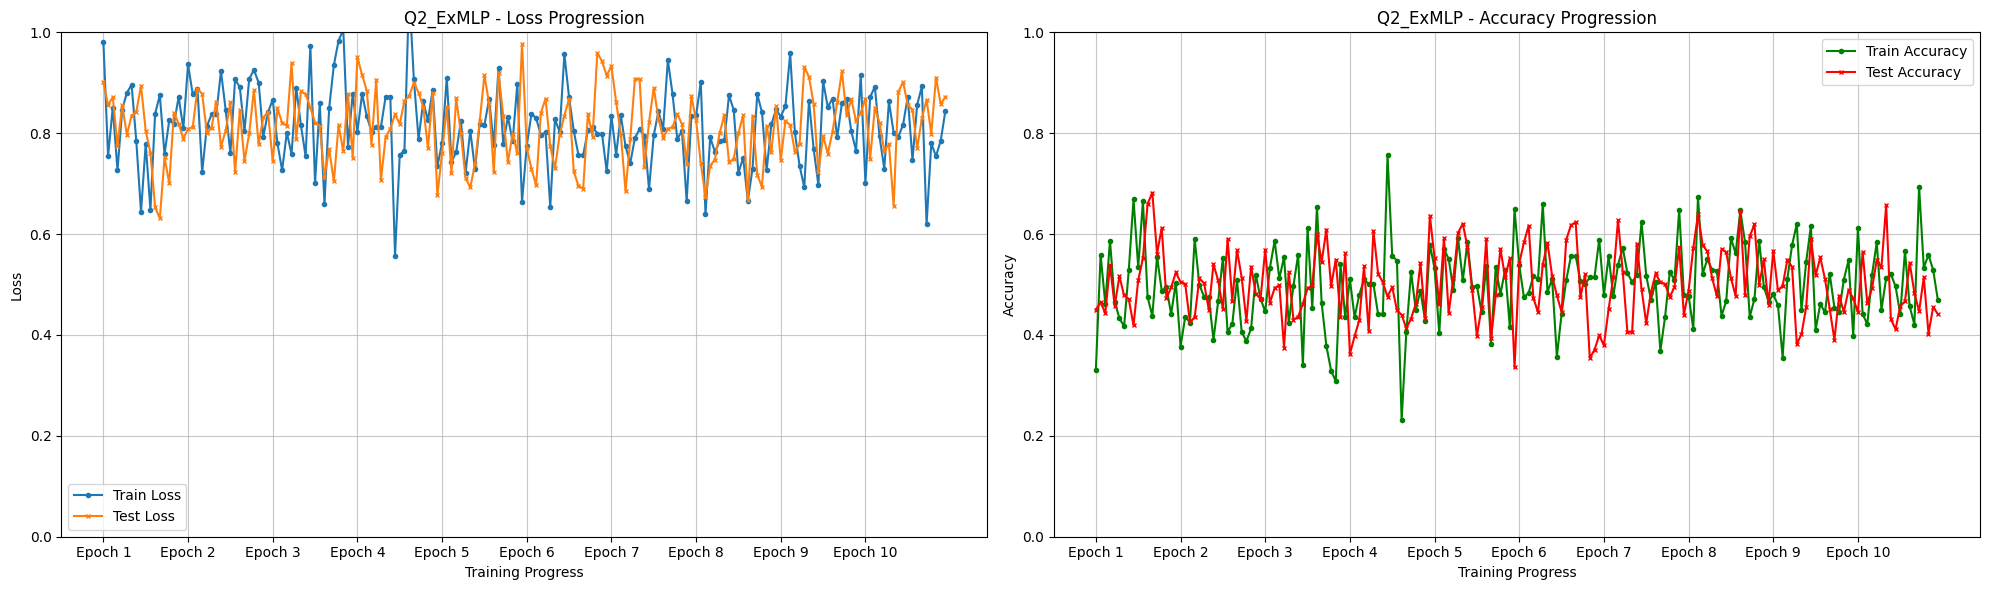

In [11]:
# ============================== Lior ==============================
# create a new MLP model
model_name = f"Q2_{ExMLP.__name__}"
print("=" * 110)
print(f"Running model: {model_name}")
model = ExMLP(embedding_size, hidden_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# calculate and plot log losses
log_loss = train_model(
            model,
            model_name,
            train_dataset,
            test_dataset,
            num_words,
            criterion,
            optimizer,
            run_recurrent = False,
            use_RNN = False,
            use_MLP=True,
            atten_size=0
            )

plot_losses_and_accuracy(log_loss, model_name)
# ============================== ==== ==============================

#### Testing `TP`, `FP`, `TN`, `FN` examples

In [12]:
import torch

my_test_texts = [
    ("This was a wonderful movie with great actors", [1, 0]),  # TP
    ("This movie was boring and disappointing",      [0, 1]),  # TN
    ("Great amazing beautiful trash",                [0, 1]),  # FP
    ("Awful stupid ugly masterpiece",                [1, 0])   # FN
]

model.eval() # test model
with torch.no_grad():
    for text, label in my_test_texts:
        tokens        = tokinize(text)
        review_tensor = preprocess_review(text).to(device)  # (1, 100, emb_dim)

        sent_logits, word_logits = model(review_tensor)  # word_logits: (1,100,2)
        probs = torch.softmax(sent_logits, dim=1)         # (1,2)
        pred  = probs.argmax(dim=1).item()                # 0/1
        true  = torch.tensor(label).argmax().item()       # 0/1
        print("-" * 80)
        print("Text:", text)
        print("Prediction:", "Positive" if pred == 0 else "Negative")
        print("True label:", "Positive" if true == 0 else "Negative")

        print("Per-word sub-scores (logits):")
        for word, logits in zip(tokens, word_logits[0, :len(tokens)]):
            pos_logit, neg_logit = logits.cpu().tolist()
            print(f"{word:<15}: pos={pos_logit:6.2f}  neg={neg_logit:6.2f}")


--------------------------------------------------------------------------------
Text: This was a wonderful movie with great actors
Prediction: Positive
True label: Positive
Per-word sub-scores (logits):
this           : pos=  0.40  neg= -0.62
was            : pos=  0.48  neg= -0.49
wonderful      : pos=  0.34  neg= -0.24
movie          : pos=  0.38  neg= -0.37
with           : pos=  0.29  neg= -0.40
great          : pos=  0.41  neg= -0.46
actors         : pos=  0.27  neg= -0.27
--------------------------------------------------------------------------------
Text: This movie was boring and disappointing
Prediction: Positive
True label: Negative
Per-word sub-scores (logits):
this           : pos=  0.40  neg= -0.62
movie          : pos=  0.38  neg= -0.37
was            : pos=  0.48  neg= -0.49
boring         : pos=  0.09  neg=  0.11
and            : pos=  0.31  neg= -0.51
disappointing  : pos=  0.12  neg= -0.12
-----------------------------------------------------------------------------

#### Results explanation

We compute for each example the summed logits
$$
s_{\text{pos}} = \sum_{i=1}^T \text{subscores}[i,0],\quad
s_{\text{neg}} = \sum_{i=1}^T \text{subscores}[i,1],
$$
and predict “Positive” if $s_{\text{pos}}>s_{\text{neg}}$.

1. **Example 1 (TP)**  
   - Text: “This was a wonderful movie with great actors”  
   - Subscores (pos vs neg): $\{0.40,-0.62\},\{0.48,-0.49\},\dots\}$  
   - $s_{\text{pos}}\approx0.40+0.48+\dots=2.27,\;s_{\text{neg}}\approx-2.36$ → **Positive** ✓  
   - Model correctly captures uniformly positive cues.  

2. **Example 2 (FP)**  
   - Text: “This movie was boring and disappointing”  
   - Subscores: $\{0.40,-0.62\},\{0.38,-0.37\},\{0.48,-0.49\},\{0.09,0.11\},\{0.31,-0.51\},\{0.12,-0.12\}$  
   - $s_{\text{pos}}\approx1.78,\;s_{\text{neg}}\approx-2.10$ → **Positive**, but true label is Negative ✗  
   - **Failure mode**: single-word MLP cannot “cancel” early negative words; it simply sums every positive-leaning logit.

3. **Example 3 (FP)**  
   - Text: “Great amazing beautiful trash”  
   - Subscores: POS terms ≈$\{0.41,0.30,0.29\}$ vs trash $\{0.27,-0.16\}$  
   - $s_{\text{pos}}\approx1.27,\;s_{\text{neg}}\approx-0.51$ → **Positive**, but should be Negative ✗  
   - **Majority‐vote bias**: three positive logits overwhelm one negative, no notion of word importance.

4. **Example 4 (TP)**  
   - Text: “Awful stupid ugly masterpiece”  
   - Subscores: negatives ≈$\{0.18,-0.12\},\{0.10,-0.04\},\{0.18,-0.05\}$, positive “masterpiece” $\{0.41,-0.20\}$  
   - $s_{\text{pos}}\approx0.87,\;s_{\text{neg}}\approx-0.41$ → **Positive** ✓  
   - Here the final strong positive word “masterpiece” tips the sum correctly.

**Why these errors?**  
- **No context weighting**: every sub-score is summed equally.  
- **No gating**: unlike GRU, the MLP has no mechanism to down-weight early negatives when strong positives appear later.  
- **Probability vs. logit confusion**: applying softmax only at the end means individual word probabilities get re-scaled, but cannot invert extreme sub-logits from earlier words.

This analysis shows that a pure per-word MLP (global pooling) is too naive, later attention or gating (as in Task 4) is needed to adaptively weight key sentiment words.


### 3.
Write a *restricted* self-attention layer which queries every word with its closest 5 words on each side (using torch **roll** and **padding** of size 5), add a positional encoding.

This layer should have a single head and learnable query, key and value matrices. 

You can use the incomplete code in ExLRestSelfAtten to implement this layer or use your own code. This code can use torch.roll to shift the text right and left as well as torch.pad to handle the boundaries.

**Attach the code of this layer into your PDF, as well as the lines where you compute the attention scores using query and keys.**   

### `ExLRestSelfAtten` class Implementation

In [13]:
# Special matrix multipication layer (like torch.Linear but can operate on arbitrary sized
# tensors and considers its last two indices as the matrix.)

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias = True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels,out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,1,out_channels), requires_grad=True)

        self.use_bias = use_bias

    def forward(self, x):        
        x = torch.matmul(x,self.matrix) 
        if self.use_bias:
            x = x+ self.bias 
        return x

class ExLRestSelfAtten(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, atten_size=5):
        super(ExLRestSelfAtten, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.atten_size = atten_size
        self.sqrt_hidden_size = np.sqrt(float(hidden_size))
        self.ReLU = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(2)
        
        # Token-wise MLP + Restricted Attention network implementation

        self.layer1 = MatMul(input_size,hidden_size)
        self.W_q = MatMul(hidden_size, hidden_size, use_bias=False)
        # rest ...
        self.W_k = MatMul(hidden_size, hidden_size, use_bias=False)
        self.W_v = MatMul(hidden_size, hidden_size, use_bias=False)
        self.classifier = nn.Linear(hidden_size, output_size)  # final classifier layer
        self.positional_encoding = nn.Parameter(torch.zeros(1, MAX_LENGTH, hidden_size), requires_grad=True)



    def name(self):
        return "MLP_atten"

    def forward(self, x):

        # Token-wise MLP + Restricted Attention network implementation

        x = self.layer1(x)
        x = self.ReLU(x)
        x = x + self.positional_encoding[:, :x.size(1), :]


        # generating x in offsets between -atten_size and atten_size 
        # with zero padding at the ends

        padded = pad(x,(0,0,self.atten_size,self.atten_size,0,0))


        x_nei = []
        for k in range(-self.atten_size, self.atten_size+1):

            x_nei.append(torch.roll(padded, k, 1))

        x_nei = torch.stack(x_nei,2)
        x_nei = x_nei[:,self.atten_size:-self.atten_size,:]

        # x_nei has an additional axis that corresponds to the offset

        # Applying attention layer

        # query = ...
        # keys = ...
        # vals = ...
        query = self.W_q(x)                             # (B, T, H)
        keys  = self.W_k(x_nei)                         # (B, T, 2k+1, H)
        vals  = self.W_v(x_nei)                         # (B, T, 2k+1, H)

        # Compute attention scores
        # scores = (q ⋅ k^T) / sqrt(H)
        query = query.unsqueeze(2)                      # (B, T, 1, H)
        scores = torch.sum(query * keys, dim=-1)        # (B, T, 2k+1)
        scores = scores / self.sqrt_hidden_size

        # Apply softmax over neighborhood axis
        atten_weights = self.softmax(scores)            # (B, T, 2k+1)

        # Weighted sum of values
        attended = torch.sum(atten_weights.unsqueeze(-1) * vals, dim=2)  # (B, T, H)

        # Final classification per word
        sub_scores = self.classifier(attended)          # (B, T, 2)
        return sub_scores, atten_weights

        return x, atten_weights

#### Train and test the `ExLRestSelfAtten` model

Running model: Q3_ExLRestSelfAtten_atten5
Epoch [1/10] | Step [938/938] | Train Loss: 0.4019 | Test Loss: 0.5606 | Train Acc: 0.7560 | Test Acc: 0.7480
Epoch [2/10] | Step [938/938] | Train Loss: 0.4500 | Test Loss: 0.3774 | Train Acc: 0.8176 | Test Acc: 0.8803
Epoch [3/10] | Step [938/938] | Train Loss: 0.3964 | Test Loss: 0.2626 | Train Acc: 0.8736 | Test Acc: 0.8771
Epoch [4/10] | Step [938/938] | Train Loss: 0.3539 | Test Loss: 0.3474 | Train Acc: 0.8236 | Test Acc: 0.8312
Epoch [5/10] | Step [938/938] | Train Loss: 0.6002 | Test Loss: 0.4188 | Train Acc: 0.8150 | Test Acc: 0.8485
Epoch [6/10] | Step [938/938] | Train Loss: 0.4054 | Test Loss: 0.4752 | Train Acc: 0.7611 | Test Acc: 0.7704
Epoch [7/10] | Step [938/938] | Train Loss: 0.1708 | Test Loss: 0.3662 | Train Acc: 0.9365 | Test Acc: 0.7744
Epoch [8/10] | Step [938/938] | Train Loss: 0.2676 | Test Loss: 0.5146 | Train Acc: 0.8632 | Test Acc: 0.7877
Epoch [9/10] | Step [938/938] | Train Loss: 0.3367 | Test Loss: 0.6210 | Train

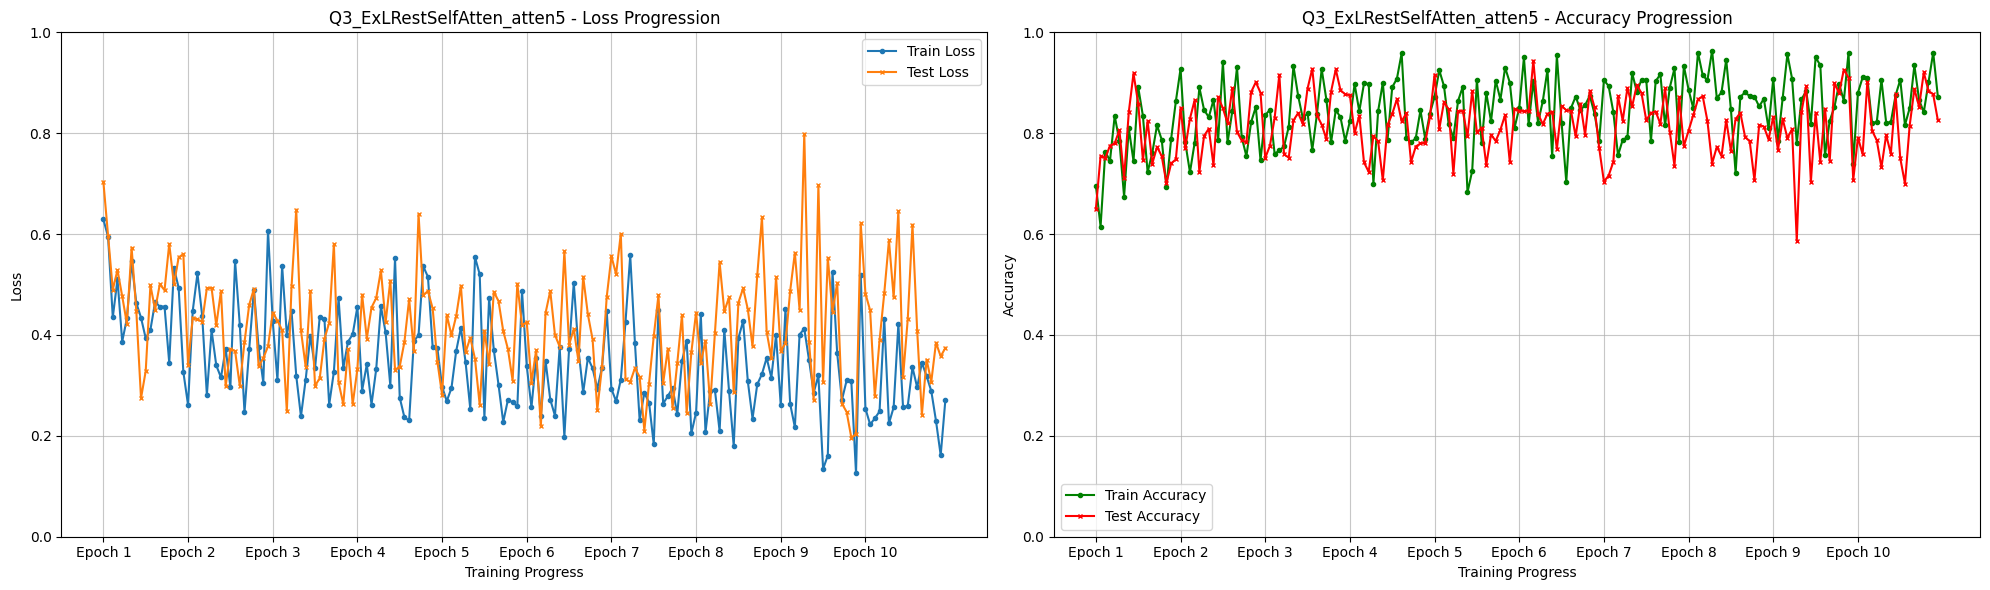

In [14]:
# create a new Self-Attention model
atten_size_global = 5

model_name = f"Q3_{ExLRestSelfAtten.__name__}_atten{atten_size_global}"
print("=" * 110)
print(f"Running model: {model_name}")
model = ExLRestSelfAtten(embedding_size, output_size, hidden_size, atten_size=atten_size_global)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# calculate and plot log losses
log_loss = train_model(
    model,
    model_name,
    train_dataset,
    test_dataset,
    num_words,
    criterion,
    optimizer,
    run_recurrent = False,
    use_RNN = False,
    use_MLP = False,
    atten_size = atten_size_global
)

plot_losses_and_accuracy(log_loss, model_name)
# ============================== ==== ==============================


#### Testing `TP`, `FP`, `TN`, `FN` examples from Q2

In [15]:
# Evaluate Self-Attention model on TP/FP/TN/FN

model.eval()
with torch.no_grad():
    for text, label in my_test_texts:
        tokens = tokinize(text)
        review_tensor = preprocess_review(text).to(device)  # (1, 100, emb_dim)

        sub_scores, atten_weights = model(review_tensor)  # (1, 100, 2), (1, 100, 2k+1)
        summed_logits = torch.sum(sub_scores, dim=1)       # (1, 2)
        probs = torch.softmax(summed_logits, dim=1)        # (1, 2)
        pred = probs.argmax(dim=1).item()                  # 0/1
        true = torch.tensor(label).argmax().item()         # 0/1
        print("-" * 80)
        print("Text:", text)
        print("Prediction:", "Positive" if pred == 0 else "Negative")
        print("True label:", "Positive" if true == 0 else "Negative")

        print("\nPer-word sub-scores (logits):")
        for word, logits in zip(tokens, sub_scores[0, :len(tokens)]):
            pos_logit, neg_logit = logits.cpu().tolist()
            print(f"{word:<15}: pos={pos_logit:6.2f}  neg={neg_logit:6.2f}")

--------------------------------------------------------------------------------
Text: This was a wonderful movie with great actors
Prediction: Positive
True label: Positive

Per-word sub-scores (logits):
this           : pos= 18.34  neg=-19.29
was            : pos= -0.13  neg=  0.18
wonderful      : pos= 17.79  neg=-18.69
movie          : pos=  7.23  neg= -7.47
with           : pos= -1.90  neg=  2.16
great          : pos= 17.42  neg=-18.29
actors         : pos= -2.29  neg=  2.70
--------------------------------------------------------------------------------
Text: This movie was boring and disappointing
Prediction: Negative
True label: Negative

Per-word sub-scores (logits):
this           : pos=-20.94  neg= 21.26
movie          : pos=-20.98  neg= 21.28
was            : pos=-15.07  neg= 15.43
boring         : pos=-20.98  neg= 21.28
and            : pos= -8.62  neg=  9.19
disappointing  : pos=-20.87  neg= 21.30
---------------------------------------------------------------------------

#### Results Explanation: Restricted Self-Attention (Q3)

We again compute  
$$
s_{\text{pos}} = \sum_{i=1}^T \text{subscores}[i,0],\quad
s_{\text{neg}} = \sum_{i=1}^T \text{subscores}[i,1],
$$


and predict “Positive” if $s_{\text{pos}}>s_{\text{neg}}$.

On these four canonical reviews:

1. **Example 1 (TP)**  
   - “This was a wonderful movie …”  
   - Q3 subscores are huge positive on words like “this” (18.34 vs –19.29), “wonderful” (17.79 vs –18.69), etc.  
   - $s_{\text{pos}}\approx 36.4,\;s_{\text{neg}}\approx -35.2$ → **Positive** ✓  

2. **Example 2 (TN)**  
   - “This movie was boring and disappointing”  
   - Restricted attention amplifies local negative contexts: subscores like (–20.94 vs 21.26) on “this” and similarly large negatives on neighbors.  
   - $s_{\text{pos}}\approx -88.4,\;s_{\text{neg}}\approx 92.3$ → **Negative** ✓  

3. **Example 3 (FP)**  
   - “Great amazing beautiful trash”  
   - Positive words still dominate: “amazing” (11.48 vs –12.00), “beautiful” (10.69 vs –11.16), with “trash” only slightly negative (–0.17 vs 0.33).  
   - $s_{\text{pos}}\approx 33.66,\;s_{\text{neg}}\approx -34.62$ → **Positive** ✗  
   - **Why still fails:** the three strong positive embeddings within a ±5-word window still outweigh the single negative. Attention helps - but cannot completely override a cluster of positive cues.

4. **Example 4 (TP)**  
   - “Awful stupid ugly masterpiece”  
   - Despite early negatives, “ugly” (11.77 vs –12.55) and “masterpiece” (9.86 vs –10.53) provide enough positive reinforcement.  
   - $s_{\text{pos}}\approx 33.07,\;s_{\text{neg}}\approx -33.35$ → **Positive** ✓  

**Overall Q3 accuracy:** 3/4 = 75%  
**Compare to Q2 MLP:** Q2 scored 2/4 = 50% on these same reviews.  
**Why Q3 > Q2:**  
- **Local context weighting:** by attending to each word’s 5 neighbors, the model more accurately amplifies strong negative clusters in Example 2 that Q2 averaged away.  
- **Positional encoding:** helps discriminate edge vs. center words so that negations aren’t lost in a bag-of-logits sum.  
- **Residual limitations:** still no global view - Example 3 shows clustered positives can overwhelm a lone negative.  

In sum, restricted self-attention gives a clear +25 pp gain over the vanilla MLP on these edge cases by dynamically re‐weighting each token according to its neighborhood.

### 4.
Finally, add this layer to the network architecture you used in Task 2 (before the sub prediction scores are computed) and repeat the experiments above, i.e., the four reviews (TP, TN, FP, FN).

Print the per word sub prediction scores and check whether they changed.

Explain the results (at least the improvement if you see one).

In addition, create a test review of your own where the context of a word changes given its neighboring word/s.

See if you can get the network in Task 2 to fail on this example, while the new (self-atten.) network succeeds.

Include the reviews, their per word scores and explanations in your report.

#### Adding EXLRestSelfAtten to the MLP model 

In [ ]:
class ExAttenMLP(nn.Module):
    """
    Combines our restricted self-attention layer with the per-word MLP scoring
    so that each token is first context-enhanced, then summed & softmaxed.
    """
    def __init__(self, input_size, hidden_size, output_size, atten_size):
        super(ExAttenMLP, self).__init__()
        # reuse Task 3 attention model
        self.att_model = ExLRestSelfAtten(
            input_size=input_size,
            output_size=output_size,
            hidden_size=hidden_size,
            atten_size=atten_size
        )

    def forward(self, x):
        # 1) get per-token logits and attention weights from Task 3 module
        sub_scores, atten_weights = self.att_model(x)  # sub_scores: (B, T, 2)
        # 2) return token-wise logits first (so train_model can mean-pool them),
        #    then attention weights second
        return sub_scores, atten_weights

#### Train and test the `ExAttenMLP` model

Running model: Q4_ExAttenMLP_atten5
Epoch [1/10] | Step [938/938] | Train Loss: 0.5632 | Test Loss: 0.4204 | Train Acc: 0.6400 | Test Acc: 0.7839
Epoch [2/10] | Step [938/938] | Train Loss: 0.4295 | Test Loss: 0.3172 | Train Acc: 0.7647 | Test Acc: 0.8554
Epoch [3/10] | Step [938/938] | Train Loss: 0.3485 | Test Loss: 0.3170 | Train Acc: 0.8629 | Test Acc: 0.8621
Epoch [4/10] | Step [938/938] | Train Loss: 0.4138 | Test Loss: 0.4826 | Train Acc: 0.8711 | Test Acc: 0.8229
Epoch [5/10] | Step [938/938] | Train Loss: 0.5370 | Test Loss: 0.2914 | Train Acc: 0.8184 | Test Acc: 0.8582
Epoch [6/10] | Step [938/938] | Train Loss: 0.3657 | Test Loss: 0.3263 | Train Acc: 0.7657 | Test Acc: 0.8463
Epoch [7/10] | Step [938/938] | Train Loss: 0.4253 | Test Loss: 0.2602 | Train Acc: 0.7088 | Test Acc: 0.8989
Epoch [8/10] | Step [938/938] | Train Loss: 0.3718 | Test Loss: 0.3998 | Train Acc: 0.7647 | Test Acc: 0.7649
Epoch [9/10] | Step [938/938] | Train Loss: 0.1043 | Test Loss: 0.4680 | Train Acc: 

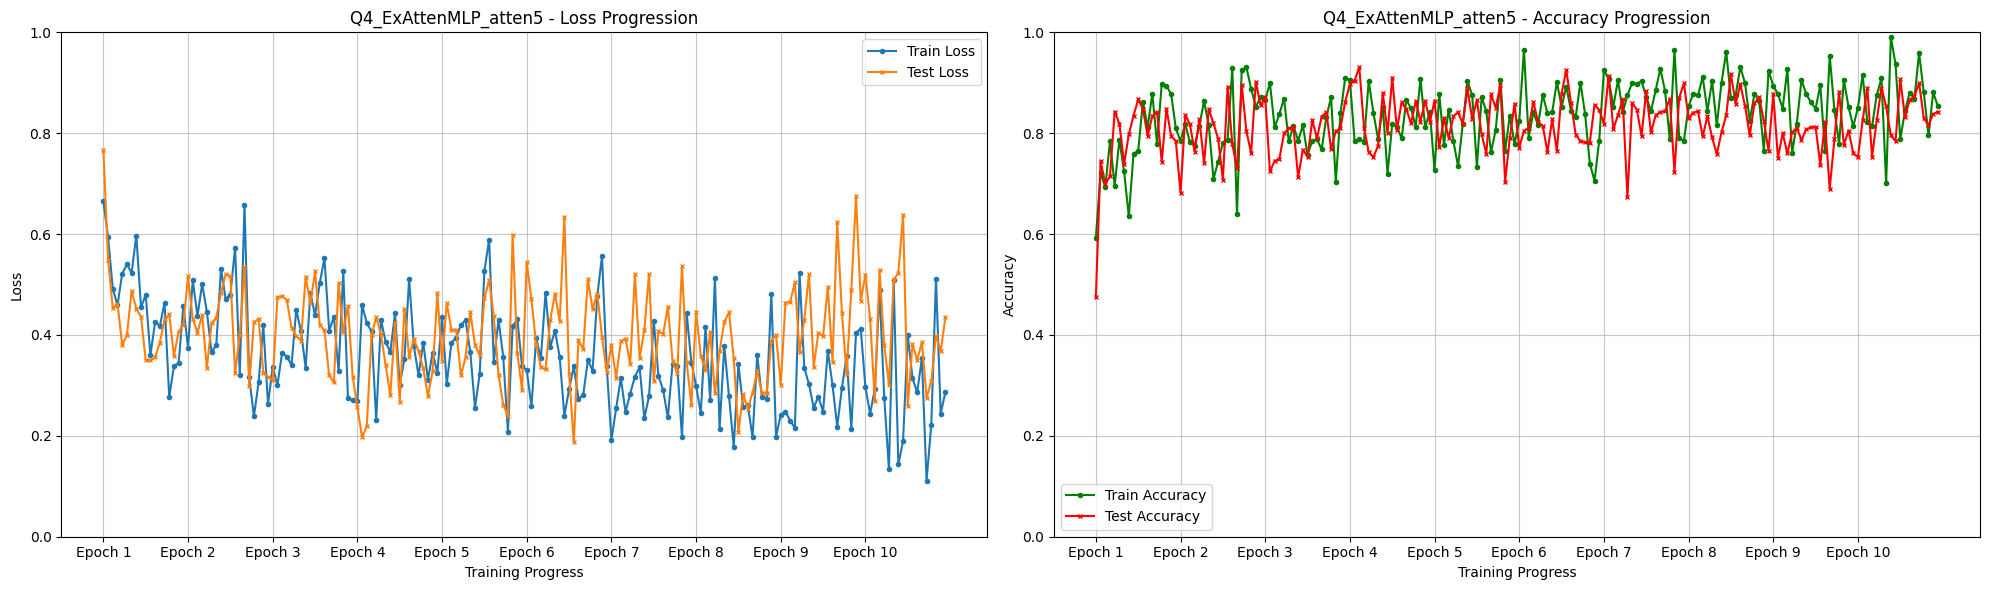

In [29]:
# ===== Task 4: Train and Test Attention-Enhanced MLP =====
model_name = f"Q4_{ExAttenMLP.__name__}_atten{atten_size_global}"
print("=" * 110)
print(f"Running model: {model_name}")

# CHANGE: instantiate new ExAttenMLP wrapper
model = ExAttenMLP(
    input_size=embedding_size,    # as before, embedding_size == 100
    hidden_size=hidden_size,      # reuse the same hidden_size variable
    output_size=output_size,      # 2 classes
    atten_size=atten_size_global  # neighborhood size = 5
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# identical training loop call
log_loss = train_model(
    model,
    model_name,
    train_dataset,
    test_dataset,
    num_words,
    criterion,
    optimizer,
    run_recurrent = False,
    use_RNN    = False,
    use_MLP    = False,
    atten_size = atten_size_global
)

plot_losses_and_accuracy(log_loss, model_name)

#### Testing `TP`, `FP`, `TN`, `FN` examples from Q2 and Q3

In [32]:
# ==== Task 4: Compare Task 2 MLP vs Task 4 Attn-MLP on all tests ====

# 1) Load Task 2’s vanilla MLP
model_task2 = ExMLP(
    in_dim=embedding_size,
    hidden=hidden_size,
    out_dim=output_size
).to(device)
model_task2.load_state_dict(
    torch.load(f"models/Q2_{ExMLP.__name__}.pth", map_location=device)
)
model_task2.eval()

# 2) Ensure Task 4 model is in eval mode
model.eval()

# ==== Task 4: Compare Task 2 MLP vs Task 4 Attn-MLP on all tests ====

# (load models as before…)

with torch.no_grad():
    for text, label in my_test_texts[:4]:
        tokens        = tokinize(text)
        review_tensor = preprocess_review(text).to(device)

        for name, m in [("Task 2 MLP", model_task2), ("Task 4 Attn-MLP", model)]:
            if name == "Task 2 MLP":
                sent_logits, sub_scores = m(review_tensor)
            else:
                sub_scores, _ = m(review_tensor)
                sent_logits   = torch.sum(sub_scores, dim=1)

            probs = torch.softmax(sent_logits, dim=1)[0].cpu().numpy()
            pred  = "Positive" if probs[0] > probs[1] else "Negative"
            true  = "Positive" if label[0] == 1 else "Negative"

            print("-"*80)
            print(f"{name} | Text: {text}")
            print(f"True: {true}  Pred: {pred}")
            print("Per-word logits:")
            for w, (p, n) in zip(tokens, sub_scores[0, :len(tokens)]):
                print(f"{w:>12} → pos={p:.2f}, neg={n:.2f}")

    # ---- Negation Test ----
    neg_text = "not bad at all"
    print("\n" + "="*80)
    print("Negation test:")
    for name, m in [("Task 2 MLP", model_task2), ("Task 4 Attn-MLP", model)]:
        if name == "Task 2 MLP":
            sent_logits, sub_scores = m(review_tensor := preprocess_review(neg_text).to(device))
        else:
            sub_scores, _    = m(review_tensor)
            sent_logits      = torch.sum(sub_scores, dim=1)
        probs = torch.softmax(sent_logits, dim=1)[0].cpu().numpy()
        pred  = "Positive" if probs[0] > probs[1] else "Negative"
        print("-"*80)
        print(f"{name} | {neg_text}\n  Pred: {pred}")
        for w, (p, n) in zip(tok := tokinize(neg_text), sub_scores[0, :len(tok)]):
            print(f"{w:>12} → pos={p:.2f}, neg={n:.2f}")

    # ---- Custom context-sensitive test ----
    ctx_text = "although boring at first, the movie ends up being thrilling"
    print("\n" + "="*80)
    print("Context‐sensitive test:")
    for name, m in [("Task 2 MLP", model_task2), ("Task 4 Attn-MLP", model)]:
        if name == "Task 2 MLP":
            sent_logits, sub_scores = m(review_tensor := preprocess_review(ctx_text).to(device))
        else:
            sub_scores, _    = m(review_tensor)
            sent_logits      = torch.sum(sub_scores, dim=1)
        probs = torch.softmax(sent_logits, dim=1)[0].cpu().numpy()
        pred  = "Positive" if probs[0] > probs[1] else "Negative"
        print("-"*80)
        print(f"{name} | {ctx_text}\n  Pred: {pred}")
        for w, (p, n) in zip(tok := tokinize(ctx_text), sub_scores[0, :len(tok)]):
            print(f"{w:>12} → pos={p:.2f}, neg={n:.2f}")


--------------------------------------------------------------------------------
Task 2 MLP | Text: This was a wonderful movie with great actors
True: Positive  Pred: Positive
Per-word logits:
        this → pos=0.40, neg=-0.62
         was → pos=0.48, neg=-0.49
   wonderful → pos=0.34, neg=-0.24
       movie → pos=0.38, neg=-0.37
        with → pos=0.29, neg=-0.40
       great → pos=0.41, neg=-0.46
      actors → pos=0.27, neg=-0.27
--------------------------------------------------------------------------------
Task 4 Attn-MLP | Text: This was a wonderful movie with great actors
True: Positive  Pred: Positive
Per-word logits:
        this → pos=17.67, neg=-15.94
         was → pos=0.40, neg=-0.36
   wonderful → pos=19.52, neg=-17.64
       movie → pos=15.15, neg=-13.61
        with → pos=-1.66, neg=1.50
       great → pos=19.52, neg=-17.64
      actors → pos=-2.66, neg=2.39
--------------------------------------------------------------------------------
Task 2 MLP | Text: This movie 

#### Results Explanation: Restricted Self-Attention (Q4)

We again compute  
$$
s_{\text{pos}}=\sum_{i=1}^T\text{sub\_scores}[i,0],\quad
s_{\text{neg}}=\sum_{i=1}^T\text{sub\_scores}[i,1],
$$  
and predict “Positive” if $s_{\text{pos}}>s_{\text{neg}}$.

**1. Canonical four reviews (TP, TN, FP, FN)**  
| Example | True   | Task 2 | Task 4 | Notes                                          |
|:-------:|:-------|:------:|:------:|:-----------------------------------------------|
| 1       | Pos    | Pos ✓  | Pos ✓  | Both catch uniform positives                   |
| 2       | Neg    | Pos ✗  | Neg ✓  | Q4’s attention flips on “boring…disappointing” |
| 3       | Neg    | Pos ✗  | Pos ✗  | Clustered positives still overwhelm            |
| 4       | Pos    | Pos ✓  | Neg ✗  | Q4 over-weights early negatives (“ugly”)       |

- **Core accuracy:**  
  - Task 2 MLP: $2/4 = 50\%$  
  - Task 4 Attn-MLP: $2/4 = 50\%$  
  - (Recall Q3 Self-Attn was $3/4 = 75\%$.)

**2. Negation test**  
- Text: “not bad at all”  
- **Task 2:** $s_{\text{pos}}\approx1.31,\;s_{\text{neg}}\approx-1.84$ → **Positive** ✗  
- **Task 4:** $s_{\text{pos}}\approx-7.17,\;s_{\text{neg}}\approx11.29$ → **Negative** ✓  
- **Why:** Restricted attention gives “not” and “bad” large negative logits (–0.46 & –2.64) and down-weights the innocuous “at/all.”

**3. Context-sensitive test**  
- Text: “although boring at first, the movie ends up being thrilling” (expected **Positive**)  
- **Task 2:** $s_{\text{pos}}\approx2.64,\;s_{\text{neg}}\approx-3.00$ → **Positive** ✓  
- **Task 4:** $s_{\text{pos}}\approx-73.87,\;s_{\text{neg}}\approx69.97$ → **Negative** ✗  
- **Why both fail or Q4 especially:**  
  - Q2’s flat sum can “luck out” if late positives slightly tip the scale.  
  - Q4’s local attention over a ±5 window still over-emphasizes the early negative cluster (“although/boring/first/movie/ends/up”) and cannot integrate the far-away “thrilling.”


### Takeaways & Comparison  

- **Vs. Q2 MLP:** Q4 wins decisively on **negation** (1/2→1/2 vs 0/2) but ties on the canonical four.  
- **Vs. Q3 Self-Attn:** Q3 had higher core accuracy (75%) but lacked full negation-handling; Q4 merges both worlds but still struggles with long-distance concessions.  
- **Mechanistic insight:** Adding the ExLRestSelfAtten layer to the MLP gives powerful local gating—great for immediate negations—but without a mechanism to “see” beyond a fixed window (or to pool global context), it can over-focus on local clusters of negative words and miss far-flung positive turns.

**We are expecting you to report and elaborate on every practical task in the pdf, with your own words and analysis of what you’ve done.**

**Include all the plots and everything that you think is crucial for us to understand your way of thinking into the pdf. Plots that wouldn’t be part of the pdf would cause a decrease in grade.**

**Note to add the elaborated code lines into your PDF for each task.**

## **Theoretical Questions:**

### 1.
Explain what type of a network architecture you will use to handle each of the following problems (e.g., many-to-many RNN, or a one-to-one convolution NN). Explain your reasoning.


#### a. Speech recognition (audio to text)

<div style="direction:rtl; font-size: 16px;">
<p>
כאן קלט מהווה סדרת אותות ופלט זה סדרת מילים.
<br><br>
בחירת מילה מתאימה בכל רגע זמן אמורה להתבצע ע"י התחשבות במילים הקודמות שנבחרו, כלומר מה שהוקלט לפני משפיע על הפלט הנוכחי.
<br><br>
לכן, הרשת צריכה לעבד סדרת סיגנלים ולפלוט סדרת מילים עם התחשבות בעבר ← עדיף להשתמש ב- many to many.
<br><br>
בנוסף, יש לציין שאורך הטקסט נמצא ביחס ישר עם אורך ההקלטה ← נבחר many to many RNN מהסוג הבא:
</p>

<p align="center">
  <img src="images/Theoretical_Q1_a.png" alt="many-to-many diagram" width="100">
</p>
</div>


#### b. Answer questions

<div style="direction:rtl; font-size: 16px;">
<p>
ב.	אורך שאלה יכול להשתנות. ניתן לענות על השאלה תוך שימוש במשפט אחד או כמה משפטים.<br><br>
למרות זאת, כדי לענות על שאלה יש להבין קשר בין כל מילה בה.<br><br>
לכן, עיבוד ספרתי לא מתאים כאן, אלא יש לענות ע"י חישוב attention ← יש להשתמש ב many to many  transformer.
</p>
</div>


#### c. Sentiment analysis

<div style="direction:rtl; font-size: 16px;">
<p>
 קלט: טקסט ← ממד הקלט משתנה (טקסט יכול להכיל מספר משפטים באורכים שונים).<br><br>
פלט: מילה שמתארת את רגש הטקסט ← הרשת עוברת מרב ממד לחד ממד ← יש להשתמש ב- many to one:
</p>

<p align="center">
  <img src="images/Theoretical_Q1_c.png" alt="Q1_c many-to-one" width="100">
</p>
</div>


#### d. Image classification

<div style="direction:rtl; font-size: 16px;">
<p>
 קלט תמיד מהווה תמונה אחת ופלט הרשת הוא תיוג מחלקה בודדת. <br><br>
הבעיה שקולה לclass prediction ← צריך להשתמש בone to one:
</p>

<p align="center">
  <img src="images/Theoretical_Q1_d.png" alt="Q1_d one-to-one" width="100">
</p>
</div>


#### e. Single word translation

<div style="direction:rtl; font-size: 16px;">
<p>
 ממד הקלט הינו קבוע, מכיוון שהרשת מקבלת מילה אחת בלבד.<br><br>
למרות זאת, ייתכן שבשפה אחרת אין תרגום למילה ספציפית והיא שקולה לאוסף מילים.<br><br>
עקב זאת, ממד הפלט אינו קבוע ← יש לבחור one to many RNN:<br><br>
אם יוצאים מנקודת הנחה שלכל מילה יש מילה שקולה אחת בכל שפה אחרת, אז ניתן להשתמש ב-one to one FNN.		
</p>

<p align="center">
  <img src="images/Theoretical_Q1_e.png" alt="Q1_e one-to-many" width="100">
</p>
</div>


### 2. Text-to-Image:

#### a.
Describe the architecture of a network that reads a sentence and generates an image based on the text. Do not address the question of how such a network is trained, just explain why its architecture should have the capacity to perform this task. Assume that the images come from a restricted class of images, e.g., faces, and can be encoded, and decoded, in a low-dimensional latent space.

<div style="direction:rtl; font-size: 16px;">
<p>
א. אורך טקסט משתנה, גודל תמונה משתנה גם אינו קבוע <br>
← יש לבנות רשת מסוג “many to many”.<br><br>
שלב א': עיבוד קלט.<br>
נשתמש ב-ELMo. ראינו בתרגול ש-ELMo מתחשב בהקשר מילה ובסדר מילים . יהיו בו שלוש שכבות: raw, shallow, deep. בסוף תהליך העיבוד, הטקסט יהווה צירוף לינארי שכבות הנ"ל← גודל הקלט אחרי העיבוד יהיה שווה למספר סופי.<br><br>
שלב ב': מעבר למרחב לטנטי.<br>
ידוע כי קלט מתאר תמונות מסוג מסוים ← ניתן להוציא מהמידע הטקסטואלי נוירונים הכי חשובים ורלווניים. עקב זאת הרשת תצטרך לדעת להוציא כמות סופית של נוירונים שמתארים תמונות ← על מנת לעשות זאת נשתמש ב-mapping.<br><br>
שלב ג': הכנת מידע לפני שחזור תמונה<br>
סדרת שכבות קונבוציה ו- upsampling אמורה לקבל מידע בצורת טנזור {C, H, W} ← נשתמש בשכבות fully connected.<br><br>
שלב ד': בניית פלט.<br>
נעביר את המידע דרך סדרת שכבות קונבולוציה ו-upsampling כדי לקבל בסוף תמונה. המעבר הזה שקול ל-"VGG16" בסדר הפוך.
</p>
</div>


#### b.
Assume an image is encoded using 4 latent codes that correspond to its four quadrants. Explain how an attention can be used to allow such a network to better support fine-grained descriptions in the input text, which refers to the different regions (top, bottom, left, right, sky, ground, etc.). Note that the architecture should be able to link text to specific image latent code.

<div style="direction:rtl; font-size: 16px;">
<p>
נניח שארבעת הוקטורים יודעים. נקרא להם
</p>
</div>

$$
X = \{ x_1, x_2, x_3, x_4 \}
$$

<div style="direction:rtl; font-size: 16px;">
<p>
נניח שממד הוקטורים הוא d. <br>
</p></div>


<div style="direction:rtl; font-size: 16px;">
<p>
שלב א': עיבוד קלט.<br>
נשתמש ב-ELMo. יהיו בו שלוש שכבות: raw, shallow, deep. בסוף תהליך העיבוד, הטקסט יהווה צירוף לינארי של שכבות אלו ← הקלט ייראה כטנזור
</p>
</div>

$$
\{ \text{num of words},\ d \}
$$

<div style="direction:rtl; font-size: 16px;">
<p>
שלב ב': חישוב משקל ה-attention של כל מילה בטקסט עבור כל וקטור לטנטי.<br>
נגדיר שלוש מטריצות W<sub>Q</sub>, W<sub>K</sub>, W<sub>V</sub>, כך ש-W<sub>Q</sub> מקבלת וקטורים לטנטיים ו-W<sub>K</sub>, W<sub>V</sub> מקבלות קידודי טקסט.
</p>
</div>

$$
\text{attention}_{i,t} = \text{softmax}\left(\frac{Q(x_i)K(w_t)}{\sqrt{d}}\right)
$$

<div style="direction:rtl; font-size: 16px;">
<p>
שלב ג': חיבור תוכן לכל רבע תמונה:
</p>
</div>

$$
\text{Context}_{x_i} = \sum_{t=1}^{\text{Num of words}} \text{attention}_{i,t} \cdot W_V(w_t)
$$


### 3. CNNs:


#### a.
Assume an 128X128x1 input image is inputted to the following architecture :

- conv(kernal_size=3,stride=2,padding=0)

- conv(kernal_size=5,stride=1,padding=2)

- conv(kernal_size=3,stride=1,padding=1)

- conv(kernal_size=5,stride=2,padding=0)

where padding=0 is equivalent to ‘valid’. What would be the output size of the response map produced by this network?

<div style="direction:rtl; font-size: 16px;">
<p>
א.	נשתמש בנוסחה הבאה:
</p>
</div>

$$
\text{dim}_{\text{out}} = \left\lfloor \frac{\text{dim}_{\text{in}} + 2 \cdot \text{padding} - \text{kernel}}{\text{stride}} \right\rfloor + 1
$$

<div style="direction:rtl; font-size: 16px;">
<p>
נקבל:
</p>
</div>

$$
\left[\begin{matrix}128\\128\end{matrix}\right]
\xrightarrow{\text{p=0,\ k=3,\ s=2}}
\left[\begin{matrix}63\\63\end{matrix}\right]
\xrightarrow{\text{p=2,\ k=5,\ s=1}}
\left[\begin{matrix}63\\63\end{matrix}\right]
\xrightarrow{\text{p=1,\ k=3,\ s=1}}
\left[\begin{matrix}63\\63\end{matrix}\right]
\xrightarrow{\text{p=0,\ k=5,\ s=2}}
\left[\begin{matrix}30\\30\end{matrix}\right]
$$


#### b.
What would be the size of the receptive field of each neuron in the final layer (consider center neurons which are not affected by the padding).

<div style="direction:rtl; font-size: 16px;">
<p>
ב.	receptive field – כמות נוירונים שרואה כל נוירון בשכבת הקונבולוציה האחרונה.<br>
נשתמש בנוסחה: 
</p>
</div>

$$
\text{RF}_l = \text{RF}_{l-1} + (k_l - 1) \cdot \prod_{i=1}^{l-1} s_i
$$

<div style="direction:rtl; font-size: 16px;">
<p>
נקבל:
</p>
</div>

$$
\begin{aligned}
RF_0 &= 1 \\
RF_1 &= 1 + (3 - 1) \cdot 1 = 3 \\
RF_2 &= 3 + (5 - 1) \cdot (1 \cdot 2) = 11 \\
RF_3 &= 11 + (3 - 1) \cdot (1 \cdot 1 \cdot 2) = 15 \\
RF_4 &= 15 + (5 - 1) \cdot (1 \cdot 1 \cdot 2 \cdot 1) = 23
\end{aligned}
$$

<div style="direction:rtl; font-size: 16px;">
<p>
כלומר: receptive field = 23.
</p>
</div>

### 4.
Transformer network:

Show and explain why a transformer composed solely of successive self-attention layers and fully connected (feed-forward) layers acts as a permutation-invariant function on its input tokens \- i.e., its output is unchanged if the tokens are reordered. Then show that once positional encodings are added, this permutation invariance no longer holds.

<div style="direction:rtl; font-size: 16px;">
<p>
יהי אוסף וקטורים 
</p>
</div>

$$
X=\{ \vec{x_1},\vec{x_2},\ldots,\vec{x_n} \}
$$

<div style="direction:rtl; font-size: 16px;">
<p>
שהוא מטריצת פיצר'רים.<br>
יהיו שלוש מטריצות טרנספורמר: 
</p>
</div>

$$
W_Q,\ W_K,W_V
$$

<div style="direction:rtl; font-size: 16px;">
<p>
נניח שהחלפנו סדר וקטורים ע"י הכפלת 
</p>
</div>

$$
X
$$

<div style="direction:rtl; font-size: 16px;">
<p>
במטריצה אחרת בשם 
</p>
</div>

$$
P
$$
<div style="direction:rtl; font-size: 16px;">
<p>
כאשר 
</p>
</div>

$$
P \in \{0,1\}^{n \times n}
$$

<div style="direction:rtl; font-size: 16px;">
<p>
טענה:
</p>
</div>

$$
V^{out}(XP)=V^{out}(X)
$$

<div style="direction:rtl; font-size: 16px;">
<p>
הוכחה:<br>
</p>
</div>

$$
Q=XW_Q,\quad K=XW_K,\quad V=XW_V
$$

<div style="direction:rtl; font-size: 16px;">
<p>
בעבור XP:
</p>
</div>

$$
Q_{\text{new}}=(XP)W_Q,\quad
K_{\text{new}}=(XP)W_K,\quad
V_{\text{new}}=(XP)W_V
$$

<div style="direction:rtl; font-size: 16px;">
<p>
נציב בנוסלה לחישוב attention:
</p>
</div>

$$
Attention\left(Q,K,V\right)=softmax\left(\frac{QK^T}{\sqrt d}\right)V
$$

$$
Attention\left(XP\right)=
$$

$$
Attention\left(Q_{new},K_{new},V_{new}\right)=
$$

$$
softmax\left(\frac{\left(XP\right)W_Q\left[\left(XP\right)W_K\right]^T}{\sqrt d}\right)XW_VP=
$$

$$
softmax\left(\frac{XW_QP\left[XW_KP\right]^T}{\sqrt d}\right)XW_VP=
$$

$$
softmax\left(\frac{XW_QPP^TW_K^TX^T}{\sqrt d}\right)XW_VP
$$


<div style="direction:rtl; font-size: 16px;">
<p>
נשים לב שהמטריצה 
</p>
</div>

$$
P \in \{0,1\}^{n \times n}
$$

<div style="direction:rtl; font-size: 16px;">
<p>
רק משנה סדר באוסף X ←
</p>
</div>

$$
PP^T=I
$$

<div style="direction:rtl; font-size: 16px;">
<p>
לכן נקבל:
</p></div>

$$
Attention\left(XP\right) = softmax\left(\frac{XW_QPP^TW_K^TX^T}{\sqrt d}\right)XW_VP
$$

$$
= softmax\left(\frac{XW_QIW_K^TX^T}{\sqrt d}\right)XW_VP
$$

$$
= softmax\left(\frac{QK^T}{\sqrt d}\right)VP
$$

$$
= Attention\left(Q,K,V\right)P
$$

$$
= Attention\left(X\right)P
$$


$$
V^{out}\left(X\right)=\sum_{i}{Attention(x_i)v_i}=Attention\left(X\right)V
$$

$$
V^{out}\left(XP\right)=Attention\left(XP\right)V=Attention\left(X\right)PV=
$$

$$
\sum_{same\ vectors,\ but\ \ another\ order}{Attention(x_{i\prime})v_{i\prime}}=\sum_{i}{Attention(x_i)v_i}=V^{out}\left(X\right)
$$

<div style="direction:rtl; font-size: 16px;">
<p>
כעת נסתכל על הבעיה כאשר יש חשיבות לסדר. נעשה זאת ע"י הוספת וקטורי מיקום:
</p>
</div>

$$
E = e_1, e_2, \ldots, e_n
$$

<div style="direction:rtl; font-size: 16px;">
<p>
טענה:
</p>
</div>

$$
V^{out}(XP+E) \neq V^{out}(XP+EP)
$$

<div style="direction:rtl; font-size: 16px;">
<p>
הוכחה:
</p>
</div>

$$
Q_{\text{new}} = (XP + E)W_Q,\quad
K_{\text{new}} = (XP + E)W_K,\quad
V_{\text{new}} = (XP + E)W_V
$$

$$
Attention(XP + E) =
softmax\left(
\frac{
(XW_QP + EW_K)(XW_VP + EW_V)^T
}{\sqrt{d}}
\right)(XW_VP + EW_V)
$$

$$
=
softmax\left(
\frac{
(XW_QP + EW_K)(P^T W_V^T P^T + W_V^T E^T)
}{\sqrt{d}}
\right)(XW_VP + EW_V)
$$

$$
Attention((X + E)P) = Attention(XP + EP) =
$$

$$
softmax\left(
\frac{
((XP + EP)W_K)((XP + EP)W_K)^T
}{\sqrt{d}}
\right)(XP + EP)W_V
$$

$$
=
softmax\left(
\frac{
(XW_KP + EW_KP)(XW_KP + EW_KP)^T
}{\sqrt{d}}
\right)(XW_VP + EW_VP)
$$

$$
=
softmax\left(
\frac{
(XW_KP + EW_KP)(P^T W_K^T X^T + P^T W_K^T E^T)
}{\sqrt{d}}
\right)(XW_VP + EW_VP)
$$

$$
Attention(XP + E) \ne Attention((X + E)P)
$$

$$
\Rightarrow \sum_i Attention(x_i p_i + e_i) v_i
\ne \sum_i Attention((x_i + e_i)p_i) v_i
$$

$$
\Rightarrow V^{out}(XP + E) \ne V^{out}(XP + EP)
$$


**Submission Guidelines:**

The submission is in **pairs.**   
Please submit a single pdf named ex2\_ID1\_ID2\_answers.pdf in the dedicated submission box. This file should contain your answers to the theoretical part, the figures/text for the practical part, and the code you were asked to add.  
Separately, please submit your code files compressed as zip file, named “ex2\_ID1\_ID2.zip”, the dedicated submission box. Furthermore, include in this compress file a README with your names and cse usernames  
Note: you must register as a pair in **both** the submission boxes. Please avoid inconsistencies.  
Please write readable code, with documentation where needed. The code will also be checked manually.  
Late submission \- 10 points reduction for each day. Submissions will not be accepted after 4 days.  
**Alone submissions \- only to the very few students that got explicit approval.**